In [305]:
import pandas as pd
import numpy as np
import sklearn

import pandas_datareader.data as web
import datetime as dt
import quandl

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Gathering Initial Data for MVP

In [126]:
#Defining start and end date for pandas data reader
start = datetime.datetime(1950, 1, 1)
end = datetime.datetime(2019, 8, 31)

In [274]:
#Getting FRED datastreams using DataReader
fred = web.DataReader(['GS10', 'TB3MS', 'USREC', 'CSCICP03USM665S'], 'fred', start, end)
fred.reset_index(drop = False, inplace = True)
fred.columns = ['Date','10_Year','3_Month','Recession','Consumer Sentiment']

In [275]:
#Making new column for 10 Year, 3 Month yield spread
fred['10Y-3M'] = df['10_Year'] - df['3_Month']

In [276]:
#Need each row to have full set of data
fred.dropna(inplace = True)
fred.reset_index(drop = True, inplace = True)

In [277]:
#Formating dates to Year/month to merge dataframes easily
fred['Date'] = fred['Date'].dt.strftime('%Y-%m')

In [413]:
fred.iloc[102:110]

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M
102,1968-07,5.50,5.31,0,100.613505,0.19
103,1968-08,5.42,5.09,0,100.598169,0.33
104,1968-09,5.46,5.19,0,100.605231,0.27
105,1968-10,5.58,5.35,0,100.679410,0.23
106,1968-11,5.70,5.45,0,100.853679,0.25
107,1968-12,6.03,5.96,0,101.048087,0.07
108,1969-01,6.04,6.14,0,101.146158,-0.10
109,1969-02,6.19,6.12,0,101.051150,0.07


In [418]:
#Getting copper and gold datastreams using DataReader
#End goal is to find copper/gold ratio
metals = quandl.get(['CHRIS/CME_HG2','LBMA/GOLD'], collapse = 'monthly')
metals.reset_index(drop = False, inplace = True)

In [419]:
metals = metals[['Date','CHRIS/CME_HG2 - Settle','LBMA/GOLD - USD (AM)']]
metals.columns = ['Date', 'Copper', 'Gold']

In [420]:
metals.dropna(inplace = True)
metals.reset_index(drop = True, inplace = True)
metals['Date'] = metals['Date'].dt.strftime('%Y-%m')

In [421]:
metals['Copper/Gold'] = np.log(metals['Copper'] / metals['Gold'])
metals = metals[['Date','Copper/Gold']].copy()

In [422]:
metals.head(3)

,Date,Copper/Gold
0,1968-07,-4.488816
1,1968-08,-4.493680
2,1968-09,-4.420542


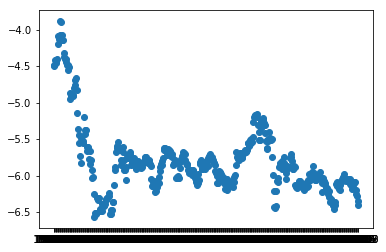

In [423]:
plt.scatter(metals['Date'], metals['Copper/Gold'])

In [424]:
df = (pd.merge(fred, metals, on='Date'))
df['Date'] = pd.to_datetime(df['Date'])

In [572]:
df.head(15)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
0,1968-07-01,5.50,5.31,0,100.613505,0.19,-4.488816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-08-01,5.42,5.09,0,100.598169,0.33,-4.493680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-09-01,5.46,5.19,0,100.605231,0.27,-4.420542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-10-01,5.58,5.35,0,100.679410,0.23,-4.460540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-11-01,5.70,5.45,0,100.853679,0.25,-4.426410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1968-12-01,6.03,5.96,0,101.048087,0.07,-4.405909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1969-07-01,6.72,7.00,0,99.920257,-0.28,-4.191297,0.19,NaN,NaN,100.613505,NaN,NaN,-4.488816,NaN,NaN
7,1969-08-01,6.69,6.98,0,99.678826,-0.29,-4.081967,0.33,NaN,NaN,100.598169,NaN,NaN,-4.493680,NaN,NaN
8,1969-09-01,7.16,7.09,0,99.440796,0.07,-4.124309,0.27,NaN,NaN,100.605231,NaN,NaN,-4.420542,NaN,NaN
9,1969-10-01,7.10,7.00,0,99.243267,0.10,-4.076685,0.23,0.19,NaN,100.679410,100.613505,NaN,-4.460540,-4.488816,NaN


## EDA

Have to shift yield spreads forward a certain amount of time to see if spreads have any predictive power
into future

Let's start with 6 months, 9 months, and 12 months

In [460]:
df['10Y-3M 6M Forward'] = df.loc[:,'10Y-3M'].shift(periods=6)
df['10Y-3M 9M Forward'] = df.loc[:,'10Y-3M'].shift(periods=9)
df['10Y-3M 12M Forward'] = df.loc[:,'10Y-3M'].shift(periods=12)

df['C Sentiment 6M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=6)
df['C Sentiment 9M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=9)
df['C Sentiment 12M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=12)

df['C/G 6M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=6)
df['C/G 9M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=9)
df['C/G 12M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=12)

In [461]:
df.head(5)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
0,1968-07-01,5.50,5.31,0,100.613505,0.19,-4.488816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-08-01,5.42,5.09,0,100.598169,0.33,-4.493680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-09-01,5.46,5.19,0,100.605231,0.27,-4.420542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-10-01,5.58,5.35,0,100.679410,0.23,-4.460540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-11-01,5.70,5.45,0,100.853679,0.25,-4.426410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [462]:
# df.dropna(inplace = True)
# df = df.drop(['10Y-2Y', '10Y-3M'], axis=1)

Quick EDA and time series plots of the spread's predicition ability

First take a look at features w/ no lag vs. recessions

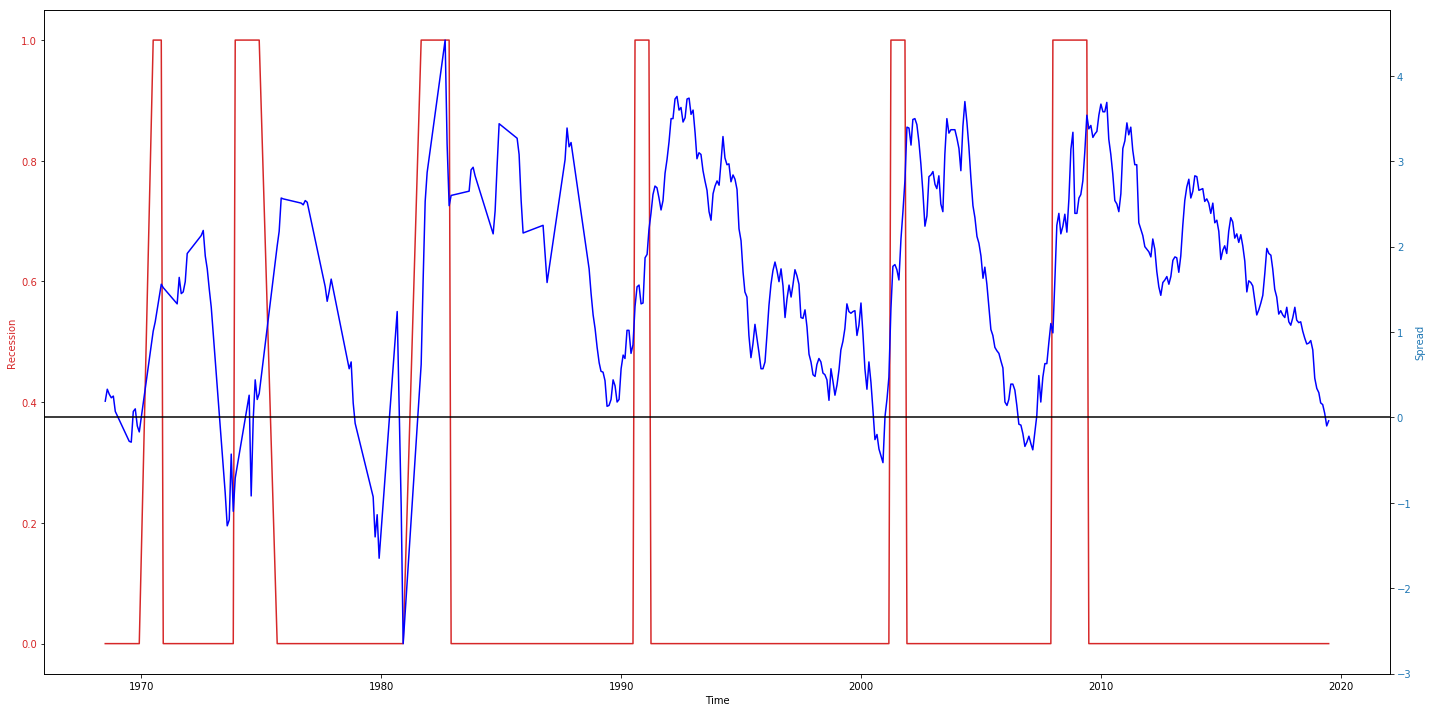

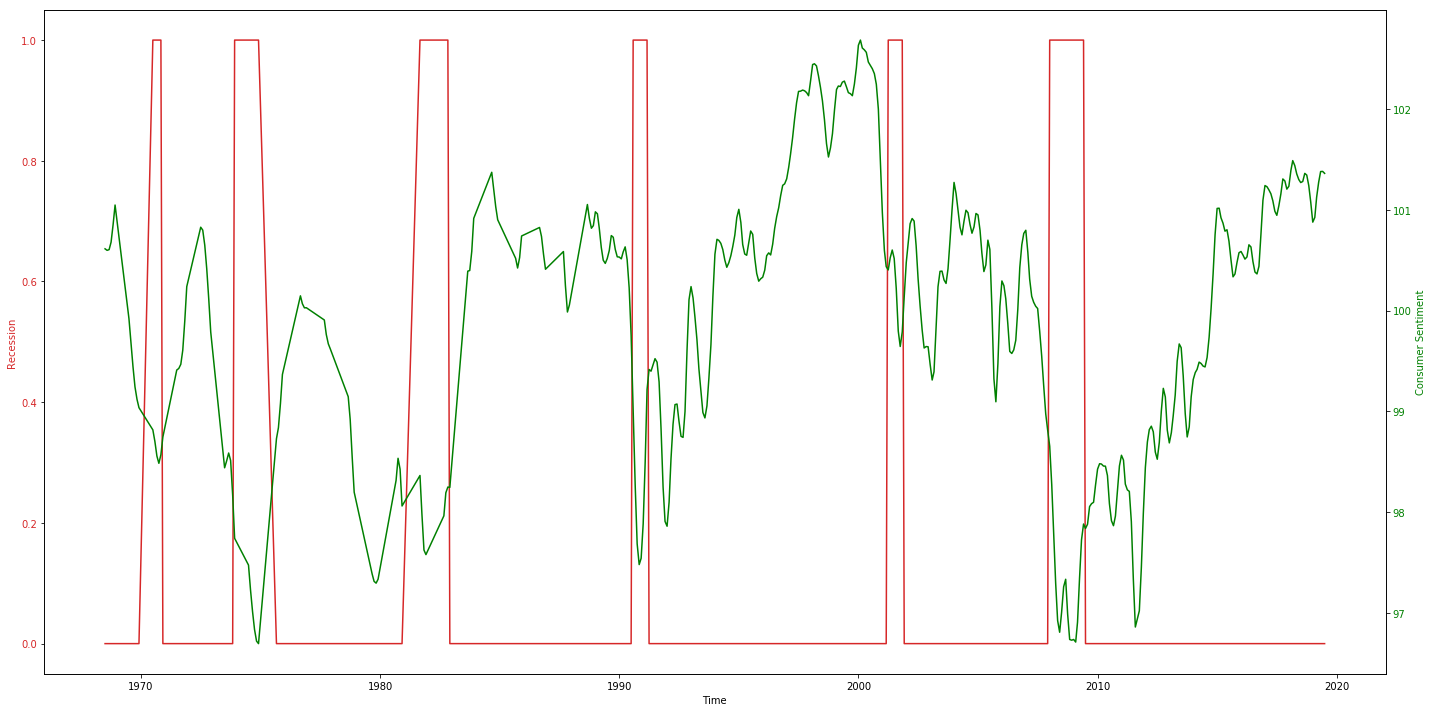

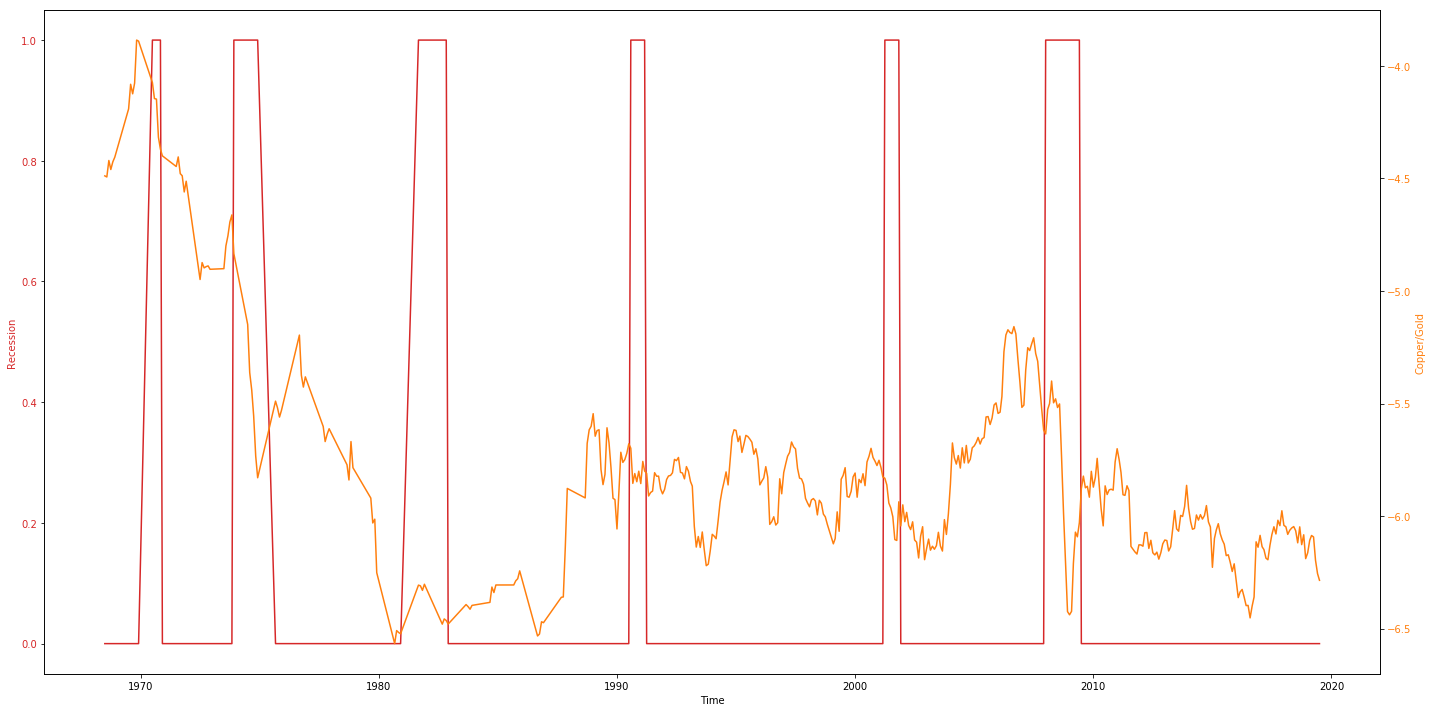

In [463]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['Consumer Sentiment'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['Copper/Gold'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

Certainly seems like spreads have led the last few recessions. Now let's look at predictative ability of spreads for 6m

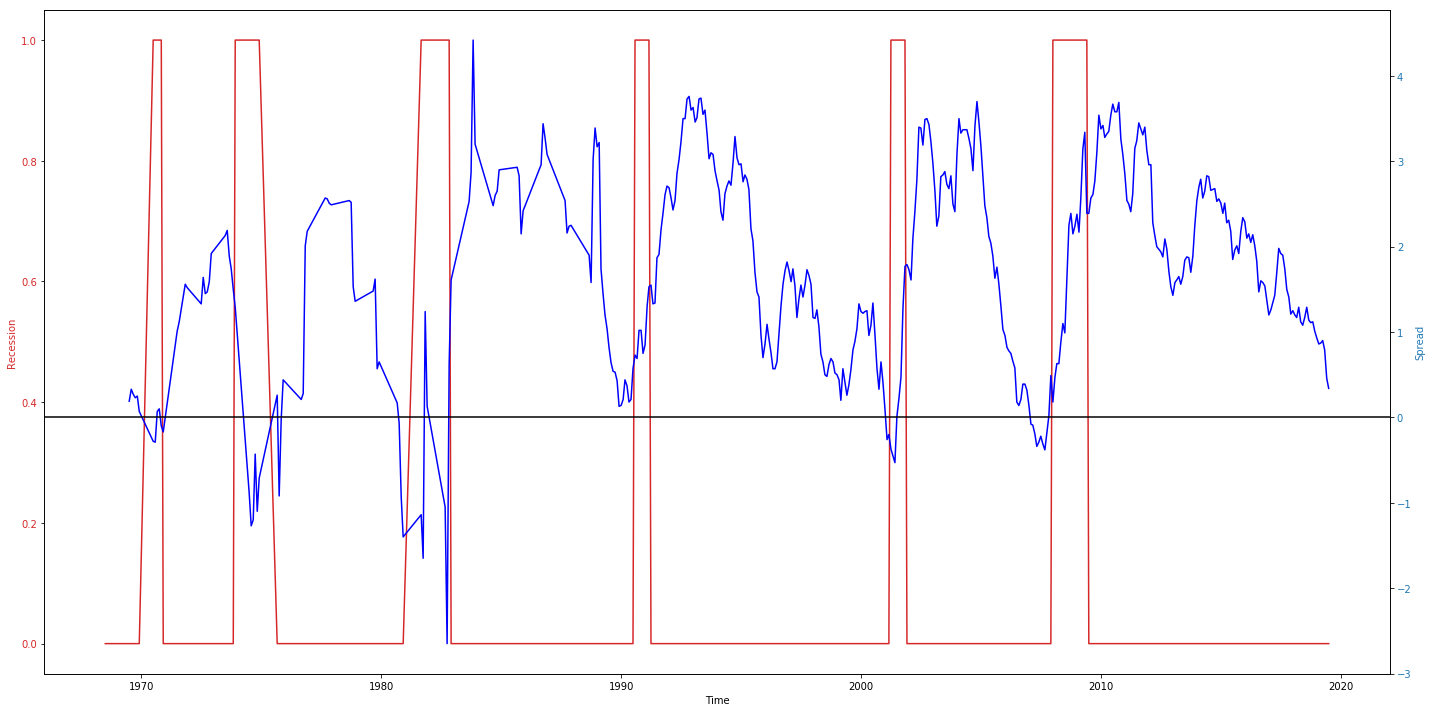

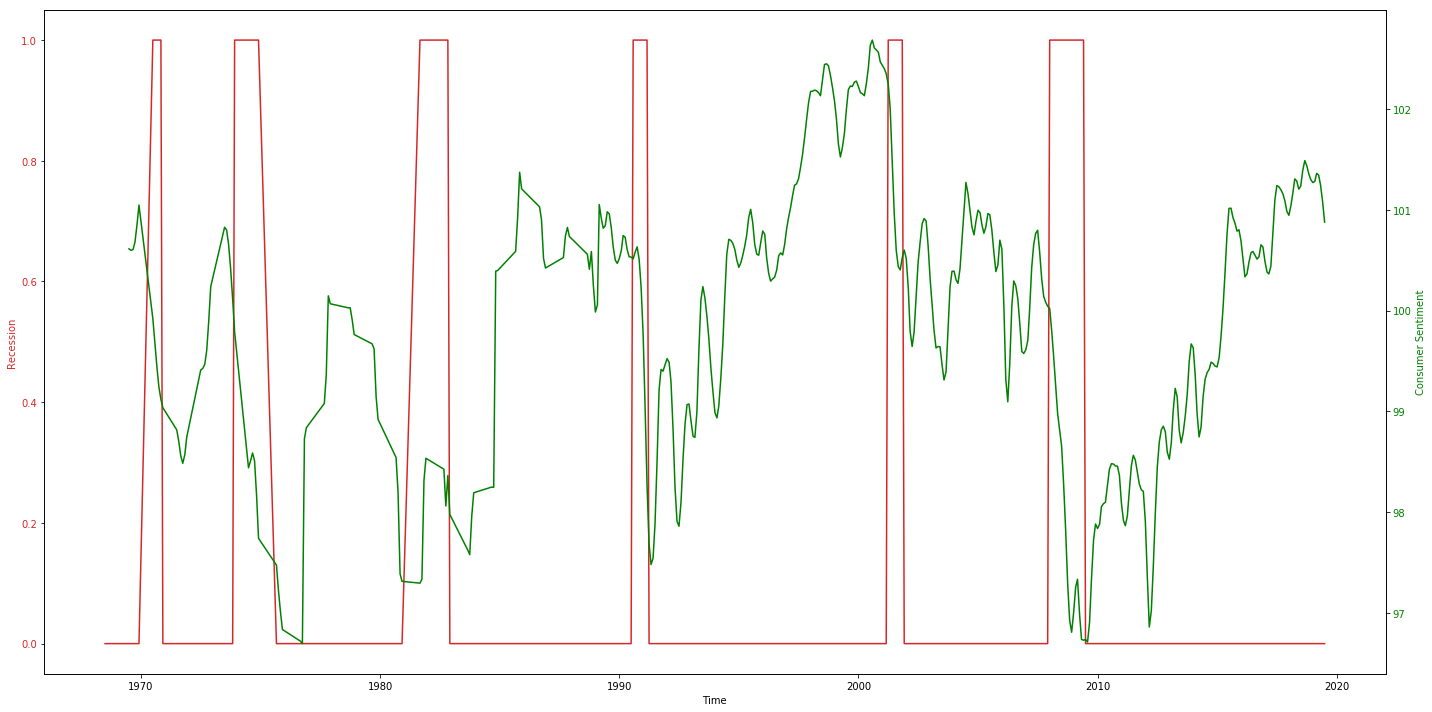

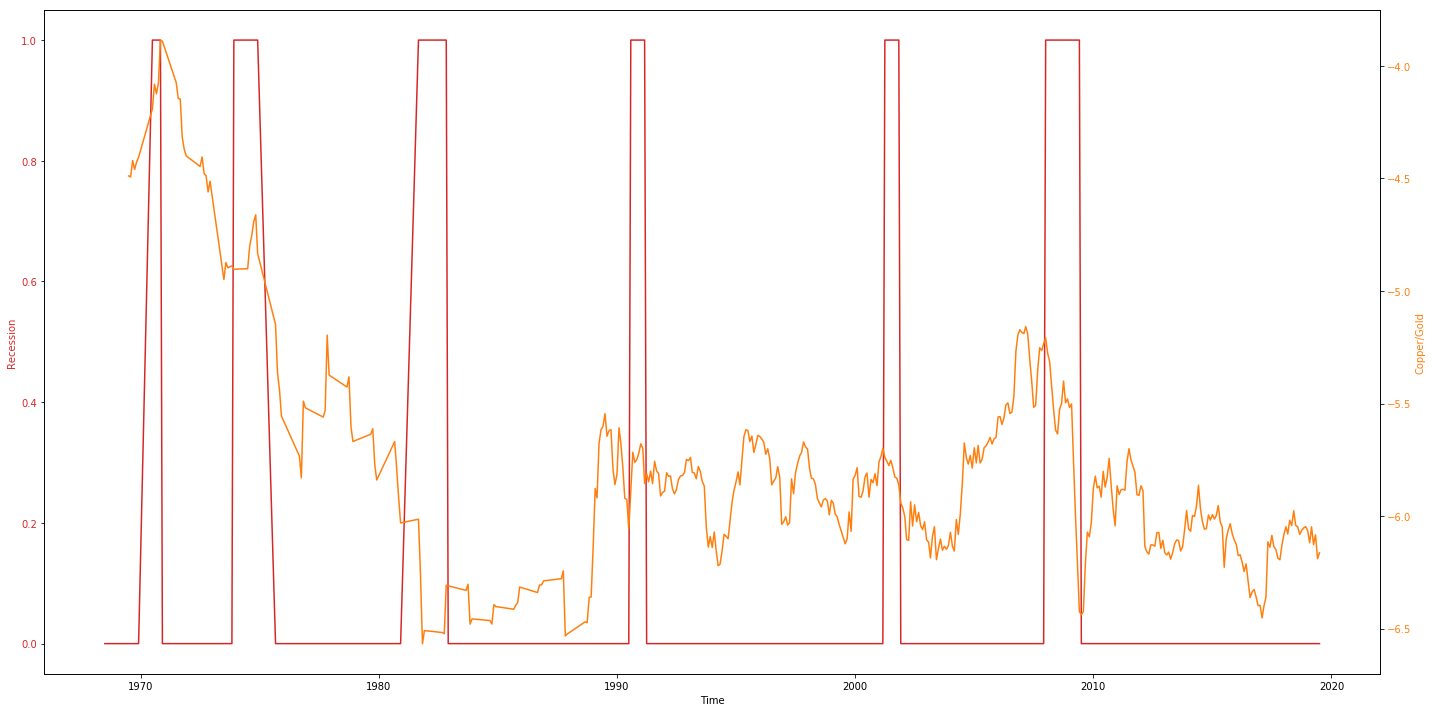

In [465]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 6M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 6M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['C/G 6M Forward'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

Not bad. Let's try 9 months too

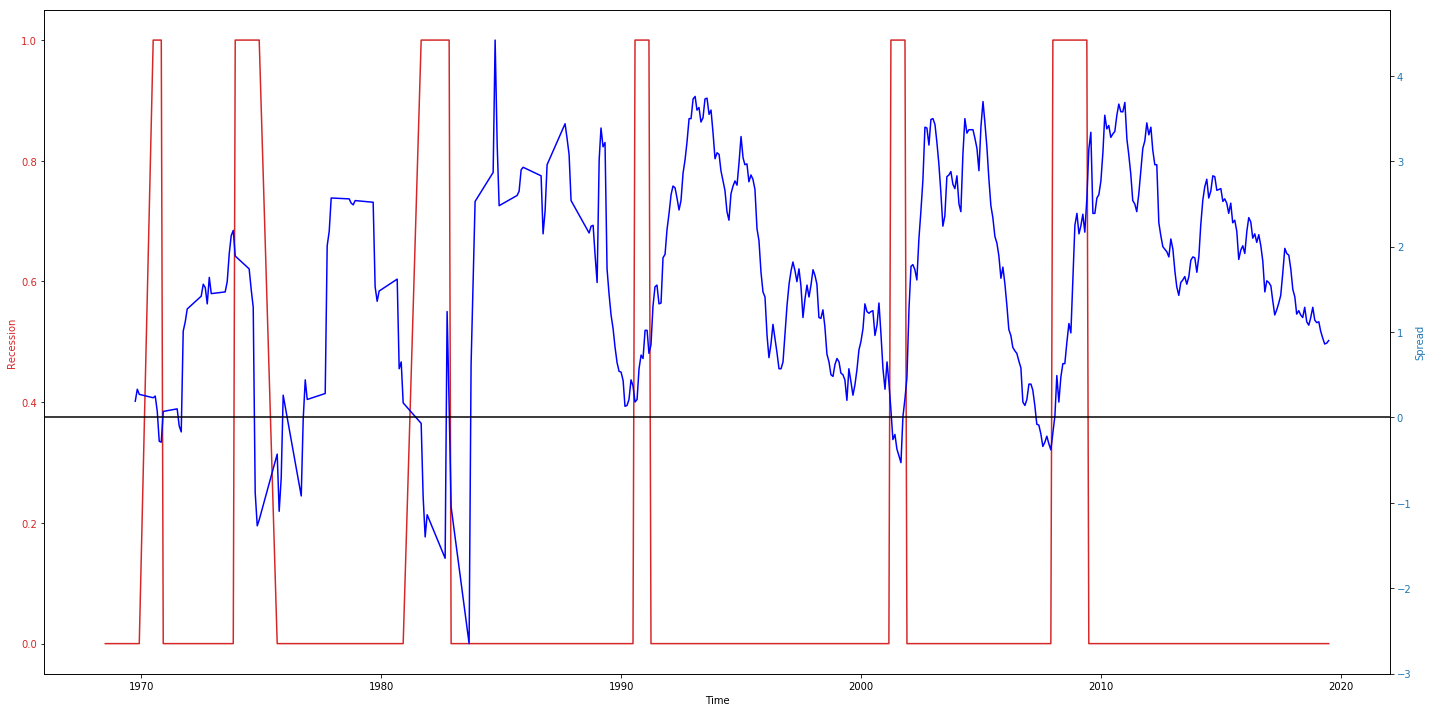

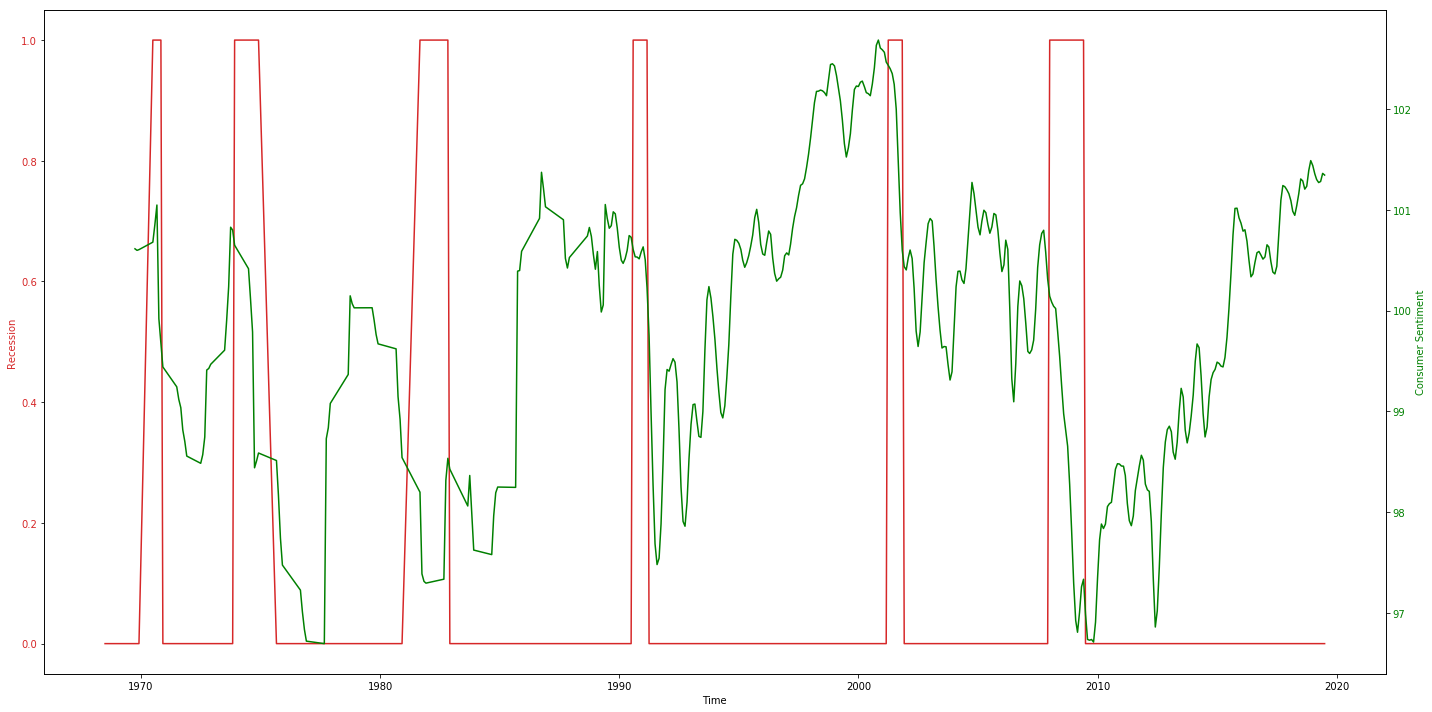

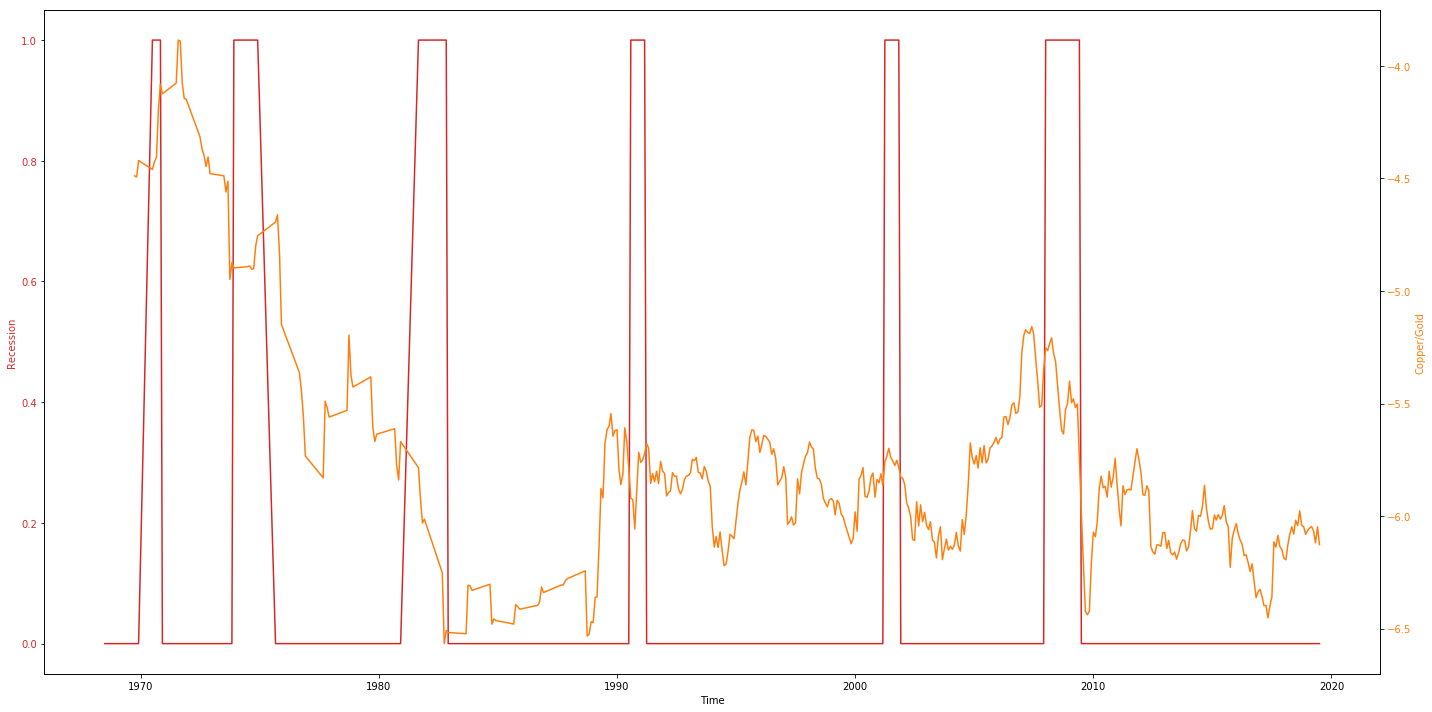

In [466]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 9M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 9M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['C/G 9M Forward'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

And one last time for 12 months

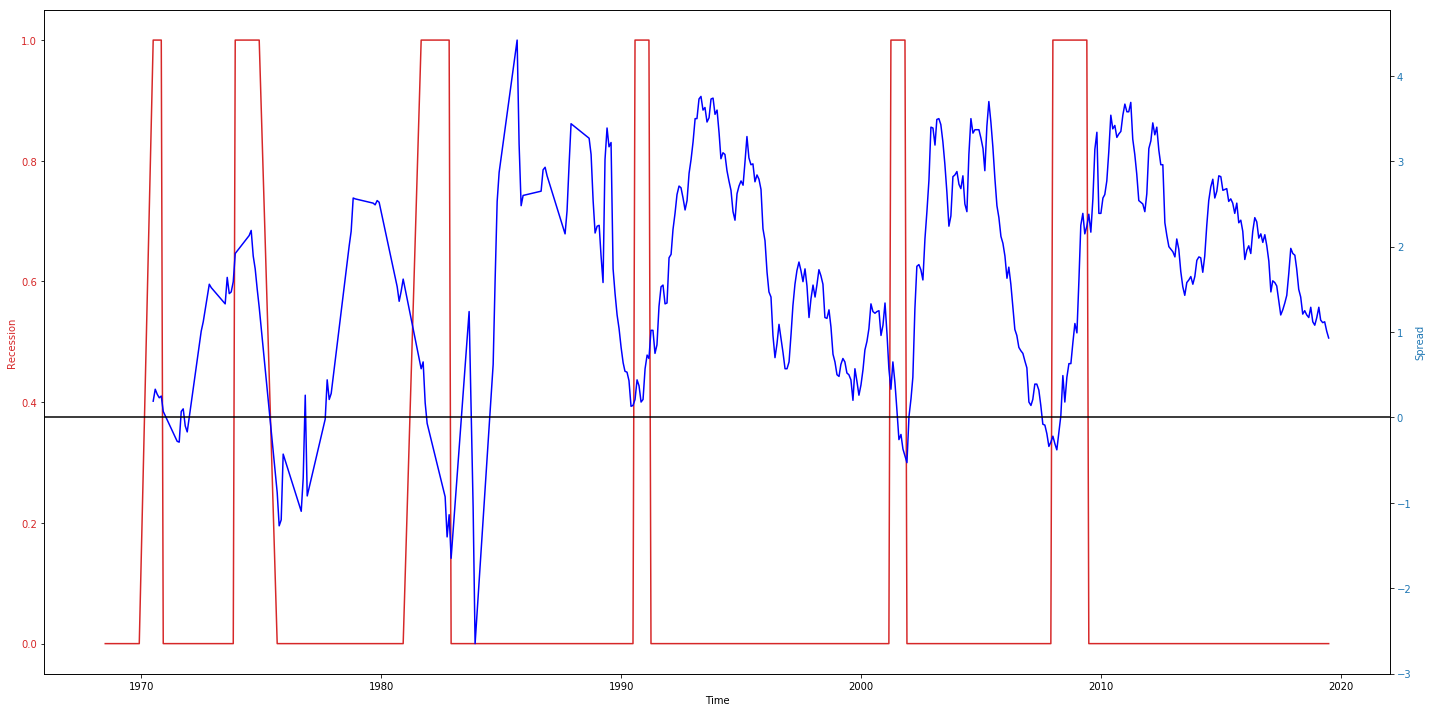

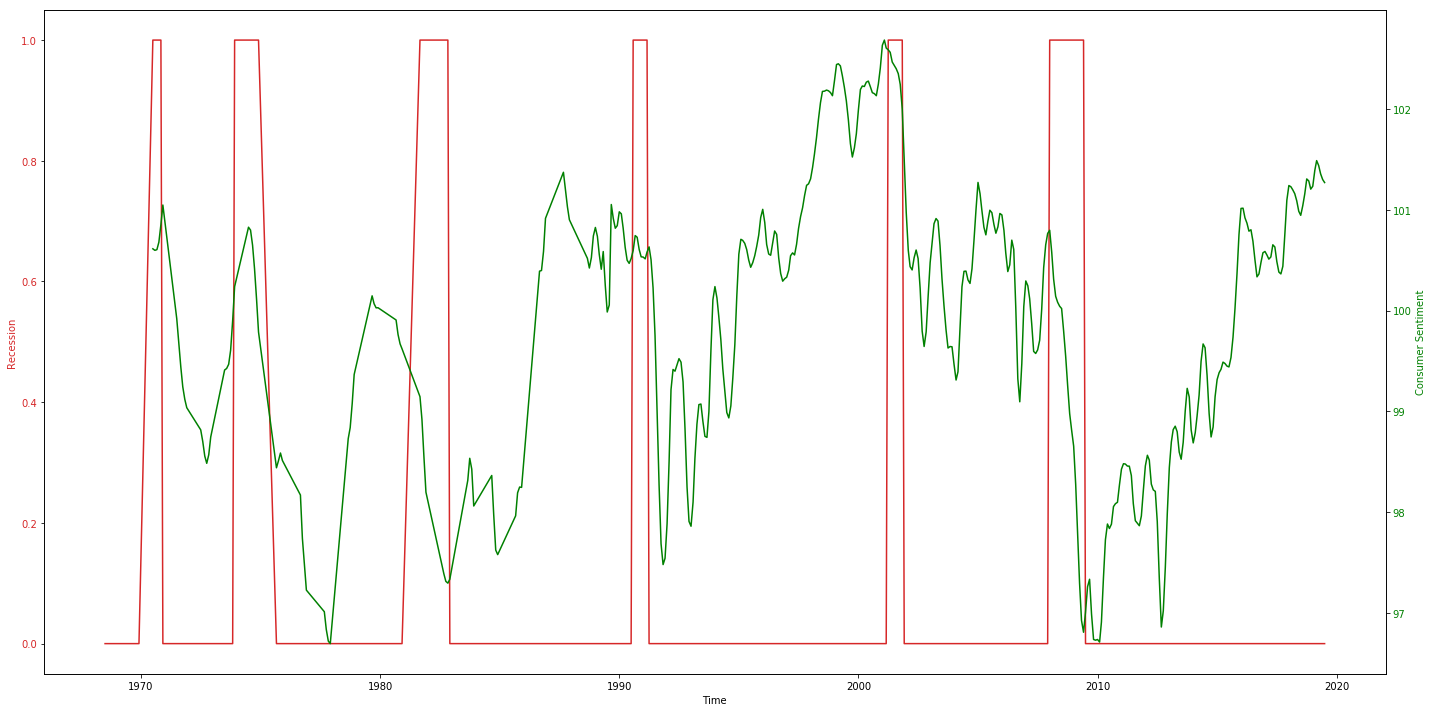

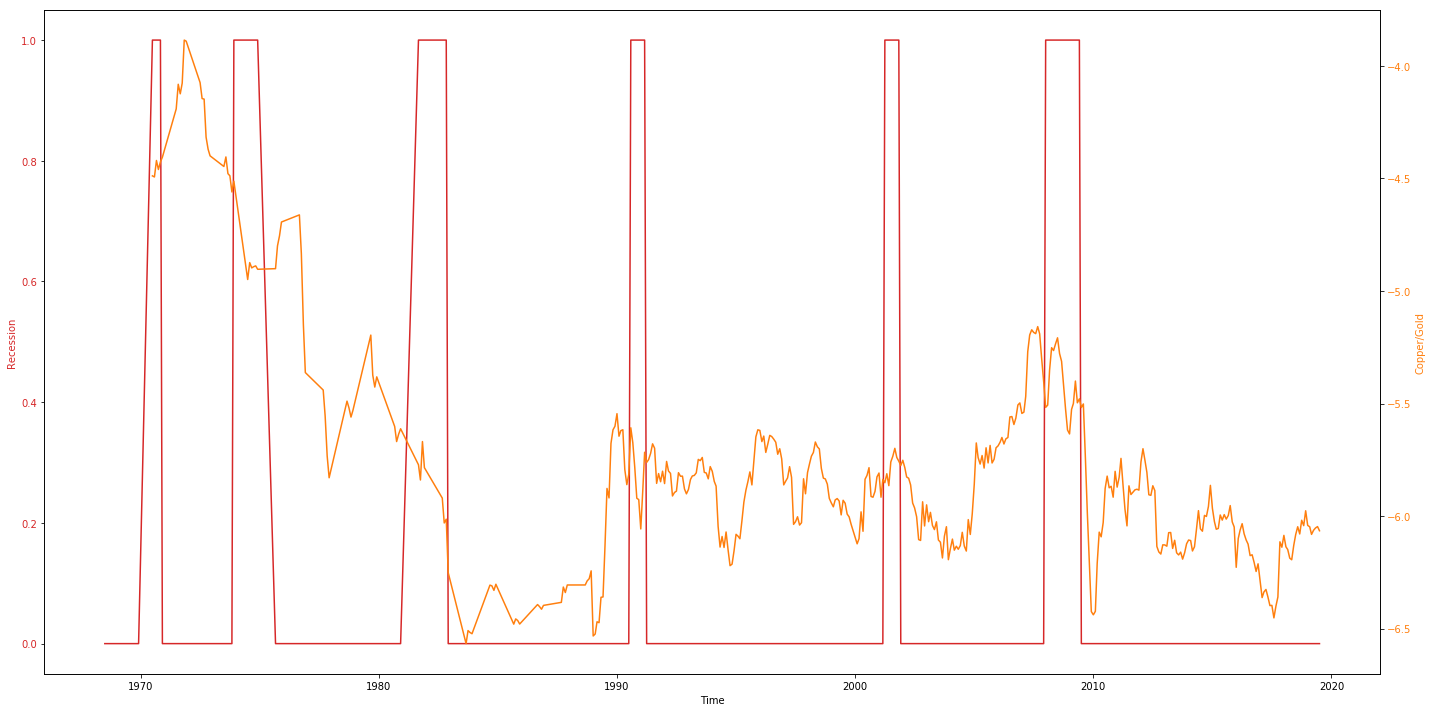

In [467]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 12M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 12M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['C/G 12M Forward'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

Overall, looks like the 6 month forward spread is best indicator of recession

## Logistic Regression for Recession Probabilities

In [552]:
df_logit = df[['Date','Recession','10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']].copy()
df_logit.dropna(inplace = True)
#452 months

In [553]:
cutoff = round(len(df_logit) * 0.666)
cutoff

305

In [554]:
cross_validation = df_logit[:cutoff]
cross_validation = cross_validation.reset_index(drop = True)
test = df_logit[cutoff:]
test = test.reset_index(drop = True)

In [555]:
test.head()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward
0,2006-10-01,0,0.39,99.871204,-5.269972
1,2006-11-01,0,0.39,99.594823,-5.195529
2,2006-12-01,0,0.32,99.574469,-5.172351
3,2007-01-01,0,0.14,99.609907,-5.184204
4,2007-02-01,0,-0.08,99.706212,-5.189537


In [556]:
y_train = cross_validation.Recession
y_test = test.Recession
X_train = cross_validation[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]
X_test = test[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]

In [557]:
std_scale = preprocessing.StandardScaler().fit(X_test)
X_test = std_scale.transform(X_test)

In [558]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)

In [559]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
y_predict = logit.predict(X_test)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

The score for logistic regression is
Training:  90.49%
Test set:  81.05%
Default threshold:
Precision: 0.0000,   Recall: 0.0000


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [560]:
rec_probs = logit.predict_proba(X_test)
temp = pd.DataFrame(rec_probs)
temp['Date'] = test['Date']

In [561]:
temp.head()

,0,1,Date
0,0.604845,0.395155,2006-10-01
1,0.585043,0.414957,2006-11-01
2,0.556946,0.443054,2006-12-01
3,0.493207,0.506793,2007-01-01
4,0.418095,0.581905,2007-02-01


In [562]:
test = pd.concat([test, temp], axis=1)

In [563]:
test.dropna(inplace = True)
test.tail()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward,0,1,Date
148,2019-03-01,0,0.87,101.362367,-6.047863,0.843377,0.156623,2019-03-01
149,2019-04-01,0,0.90,101.345492,-6.126769,0.851414,0.148586,2019-04-01
150,2019-05-01,0,0.79,101.240690,-6.083086,0.824500,0.175500,2019-05-01
151,2019-06-01,0,0.46,101.076506,-6.188920,0.740650,0.259350,2019-06-01
152,2019-07-01,0,0.34,100.878300,-6.163211,0.694205,0.305795,2019-07-01


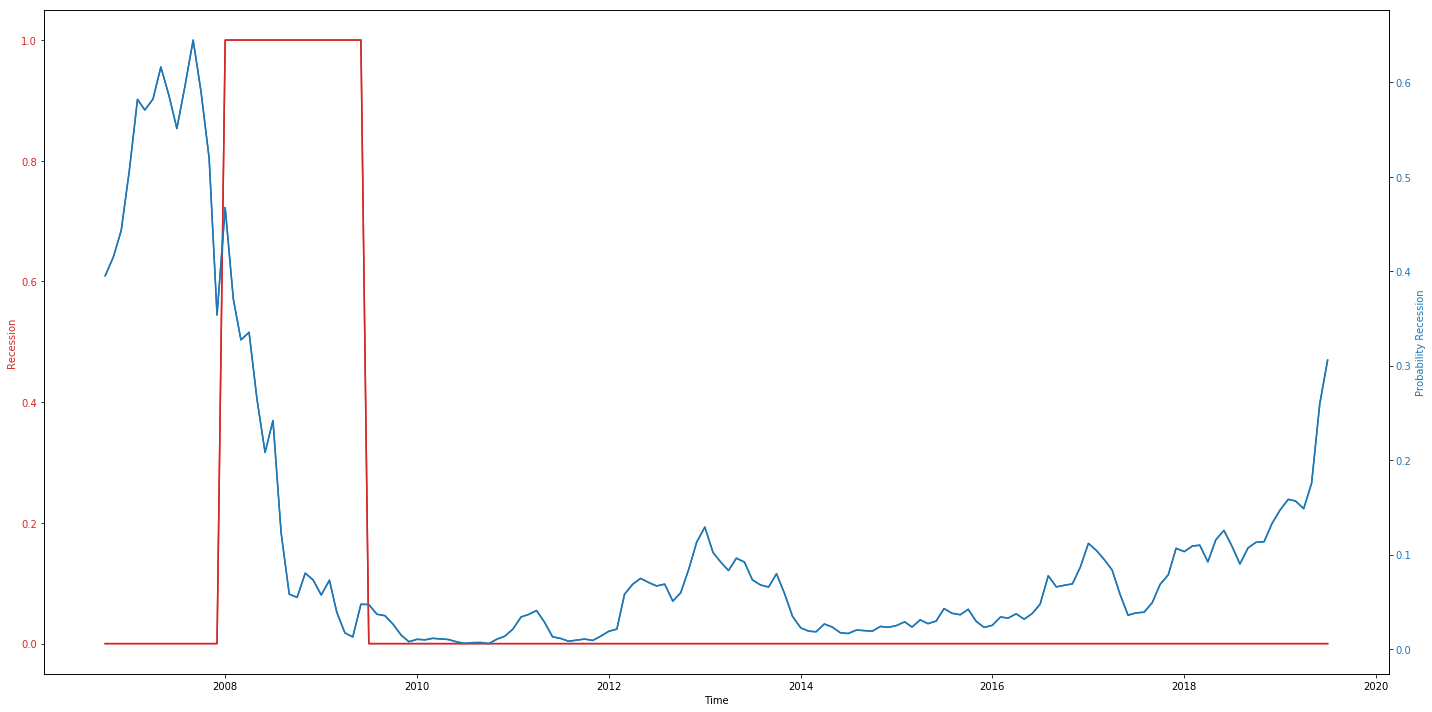

In [564]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(test['Date'], test['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(test['Date'], test[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Seems to be doing an ok job, but let's refit on entire dataset now

In [565]:
y = df_logit.Recession
X = df_logit[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]

In [566]:
std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

In [567]:
logit = LogisticRegression(C = 0.95)
logit.fit(X, y)
y_predict = logit.predict(X)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [568]:
rec_probs_2 = logit.predict_proba(X)
temp = pd.DataFrame(rec_probs_2)
temp.head()

,0,1
0,0.763857,0.236143
1,0.783503,0.216497
2,0.770609,0.229391
3,0.775436,0.224564
4,0.794724,0.205276


In [569]:
df_logit.reset_index(drop = True, inplace = True)
df_logit['Rec Prob'] = temp[1]

In [570]:
df_logit.head()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward,Rec Prob
0,1969-07-01,0,0.19,100.613505,-4.488816,0.236143
1,1969-08-01,0,0.33,100.598169,-4.493680,0.216497
2,1969-09-01,0,0.27,100.605231,-4.420542,0.229391
3,1969-10-01,0,0.23,100.679410,-4.460540,0.224564
4,1969-11-01,0,0.25,100.853679,-4.426410,0.205276


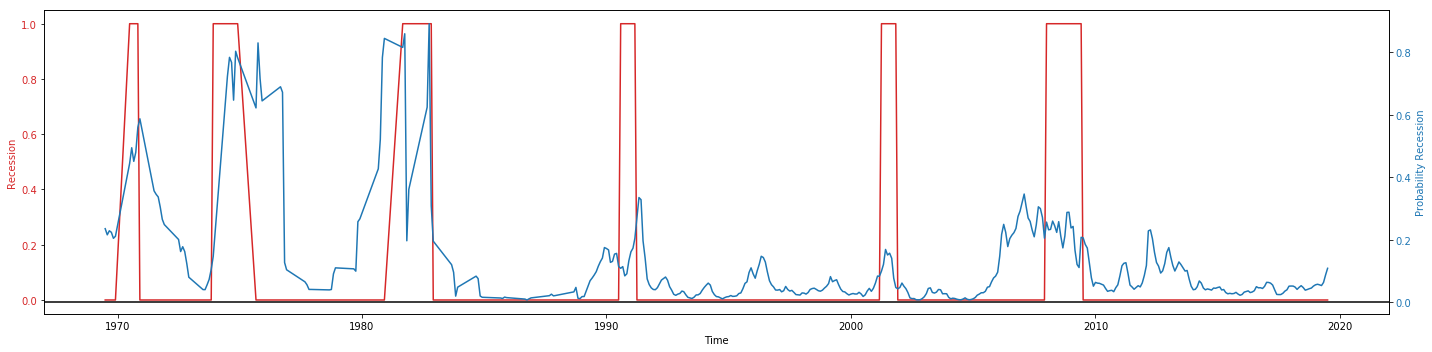

In [571]:
fig, ax1 = plt.subplots(figsize=(20,5))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df_logit['Date'], df_logit['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(df_logit['Date'], df_logit['Rec Prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()